# Solution 1: Creatinine Prediction
## Objective: Predict serum creatinine levels using selected features

### Features Used:
- Age
- Albumin (urine)
- RBC (Red Blood Cells - nominal)
- Pus Cell (nominal)
- Bacteria (nominal)
- Urine pH

### Models:
1. Perceptron (baseline)
2. XGBoost (ensemble)
3. CatBoost (ensemble)

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Initial Exploration

In [38]:
# Load dataset from UCI repository using ucimlrepo
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
chronic_kidney_disease = fetch_ucirepo(id=336) 
  
# data (as pandas dataframes) 
X_data = chronic_kidney_disease.data.features 
y_data = chronic_kidney_disease.data.targets 

# Combine features and target into a single dataframe
df = pd.concat([X_data, y_data], axis=1)

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())


Dataset Shape: (400, 25)

First few rows:
    age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...   pcv    wbcc  rbcc  htn   dm  cad  appet   pe  ane class  
0  121.0  ...  44.0  7800.0   5.2  yes  yes   no   good   no   no   ckd  
1    NaN  ...  38.0  6000.0   NaN   no   no   no   good   no   no   ckd  
2  423.0  ...  31.0  7500.0   NaN   no  yes   no   poor   no  yes   ckd  
3  117.0  ...  32.0  6700.0   3.9  yes   no   no   poor  yes  yes   ckd  
4  106.0  ...  35.0  7300.0   4.6   no   no   no   good   no   no   ckd  

[5 rows x 25 columns]


In [39]:
# Display dataset information
print("Dataset Info:")
df.info()
print("\nColumn Names:")
print(df.columns.tolist())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    o

In [40]:
# Display statistical summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


## 2. Feature Selection and Data Preprocessing

In [41]:
# Select required features based on specification
# Features: Age, Albumin (al - urine), RBC (rbc), Pus Cell (pc), Bacteria (ba)
# Target: Serum Creatinine (sc)

selected_features = ['age', 'al', 'rbc', 'pc', 'ba']
target = 'sc'

# Create working dataframe with selected features and target
df_work = df[selected_features + [target]].copy()

print("Working Dataset Shape:", df_work.shape)
print("\nMissing Values:")
print(df_work.isnull().sum())
print("\nMissing Values Percentage:")
print((df_work.isnull().sum() / len(df_work)) * 100)

Working Dataset Shape: (400, 6)

Missing Values:
age      9
al      46
rbc    152
pc      65
ba       4
sc      17
dtype: int64

Missing Values Percentage:
age     2.25
al     11.50
rbc    38.00
pc     16.25
ba      1.00
sc      4.25
dtype: float64


In [42]:
# Check for '?' or other missing value indicators
print("Checking for '?' or '\\t?' values:")
for col in df_work.columns:
    if df_work[col].dtype == object:
        unique_vals = df_work[col].unique()
        print(f"\n{col}: {unique_vals}")

Checking for '?' or '\t?' values:

rbc: [nan 'normal' 'abnormal']

pc: ['normal' 'abnormal' nan]

ba: ['notpresent' 'present' nan]


In [43]:
# Replace missing value indicators with NaN
df_work = df_work.replace(['?', '\t?', ' ?', '? '], np.nan)

# Convert numeric columns to appropriate types
numeric_cols = ['age', 'al', 'sc']
for col in numeric_cols:
    df_work[col] = pd.to_numeric(df_work[col], errors='coerce')

print("Missing Values After Conversion:")
print(df_work.isnull().sum())
print("\nData Types:")
print(df_work.dtypes)

Missing Values After Conversion:
age      9
al      46
rbc    152
pc      65
ba       4
sc      17
dtype: int64

Data Types:
age    float64
al     float64
rbc     object
pc      object
ba      object
sc     float64
dtype: object


In [44]:
# Handle missing values
# For numeric features: impute with median
# For categorical features: impute with mode

from sklearn.impute import SimpleImputer

# Numeric imputation
numeric_imputer = SimpleImputer(strategy='median')
df_work[numeric_cols] = numeric_imputer.fit_transform(df_work[numeric_cols])

# Categorical imputation
categorical_cols = ['rbc', 'pc', 'ba']
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_work[categorical_cols] = categorical_imputer.fit_transform(df_work[categorical_cols].values.reshape(-1, len(categorical_cols)))

print("Missing Values After Imputation:")
print(df_work.isnull().sum())

Missing Values After Imputation:
age    0
al     0
rbc    0
pc     0
ba     0
sc     0
dtype: int64


## 3. Exploratory Data Analysis (EDA)

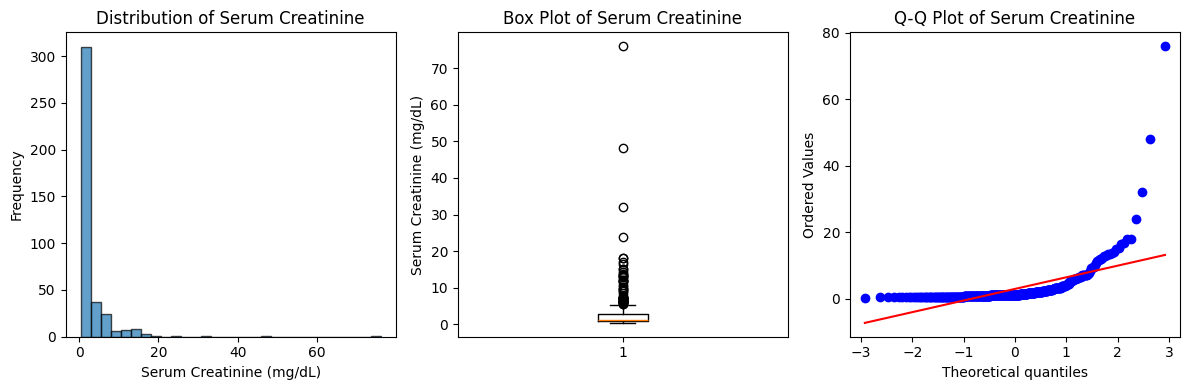

Target Variable Statistics:
count    400.000000
mean       2.997125
std        5.628886
min        0.400000
25%        0.900000
50%        1.300000
75%        2.725000
max       76.000000
Name: sc, dtype: float64


In [45]:
# Distribution of target variable (Serum Creatinine)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df_work['sc'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Serum Creatinine (mg/dL)')
plt.ylabel('Frequency')
plt.title('Distribution of Serum Creatinine')

plt.subplot(1, 3, 2)
plt.boxplot(df_work['sc'])
plt.ylabel('Serum Creatinine (mg/dL)')
plt.title('Box Plot of Serum Creatinine')

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(df_work['sc'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Serum Creatinine')

plt.tight_layout()
plt.show()

print("Target Variable Statistics:")
print(df_work['sc'].describe())

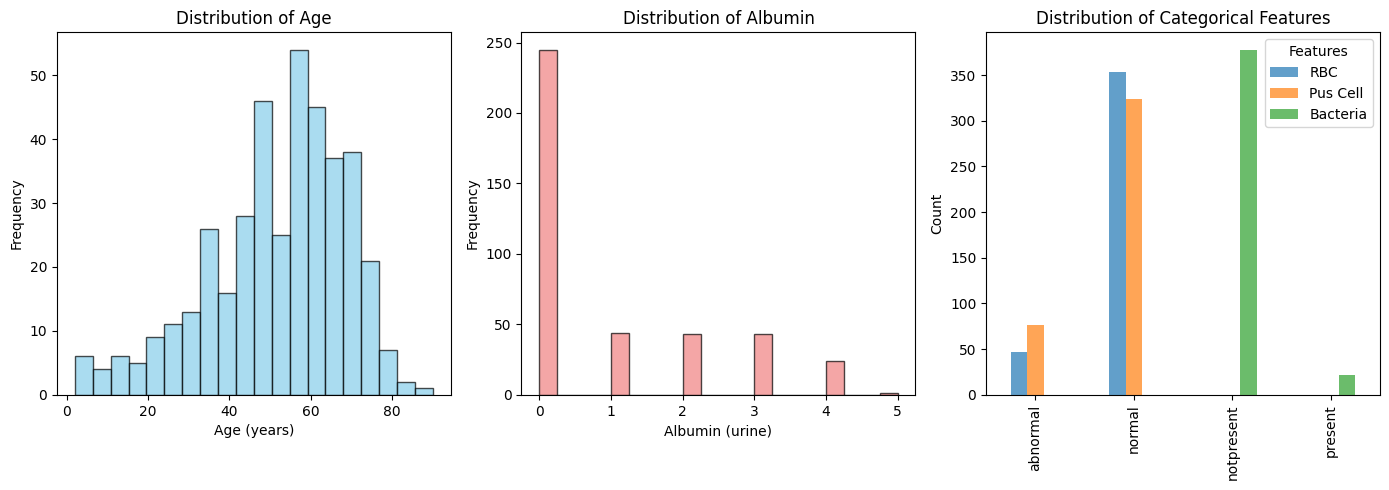

In [46]:
# Distribution of numeric features
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].hist(df_work['age'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Age')

axes[1].hist(df_work['al'], bins=20, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xlabel('Albumin (urine)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Albumin')

# Categorical feature distribution
categorical_counts = pd.DataFrame({
    'RBC': df_work['rbc'].value_counts(),
    'Pus Cell': df_work['pc'].value_counts(),
    'Bacteria': df_work['ba'].value_counts()
})
categorical_counts.plot(kind='bar', ax=axes[2], alpha=0.7)
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Categorical Features')
axes[2].legend(title='Features')

plt.tight_layout()
plt.show()

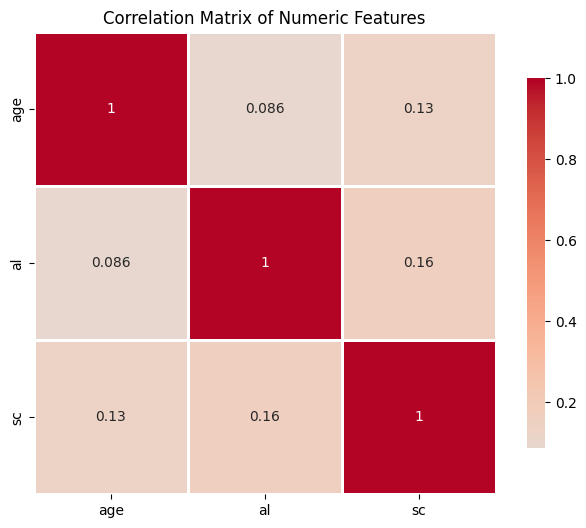


Correlation with Target (Serum Creatinine):
sc     1.000000
al     0.161310
age    0.133985
Name: sc, dtype: float64


In [47]:
# Correlation analysis for numeric features
numeric_features = ['age', 'al', 'sc']
correlation_matrix = df_work[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features')
plt.show()

print("\nCorrelation with Target (Serum Creatinine):")
print(correlation_matrix['sc'].sort_values(ascending=False))

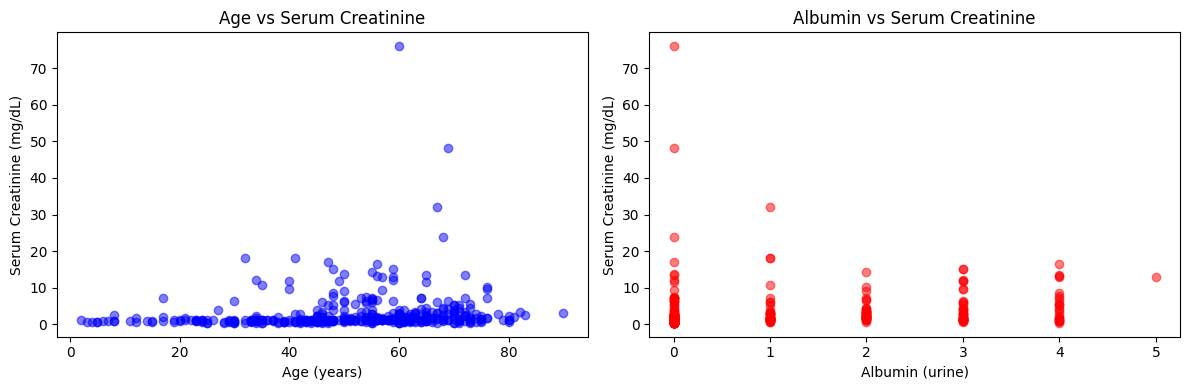

In [48]:
# Scatter plots: Numeric features vs Target
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df_work['age'], df_work['sc'], alpha=0.5, color='blue')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Serum Creatinine (mg/dL)')
axes[0].set_title('Age vs Serum Creatinine')

axes[1].scatter(df_work['al'], df_work['sc'], alpha=0.5, color='red')
axes[1].set_xlabel('Albumin (urine)')
axes[1].set_ylabel('Serum Creatinine (mg/dL)')
axes[1].set_title('Albumin vs Serum Creatinine')

plt.tight_layout()
plt.show()

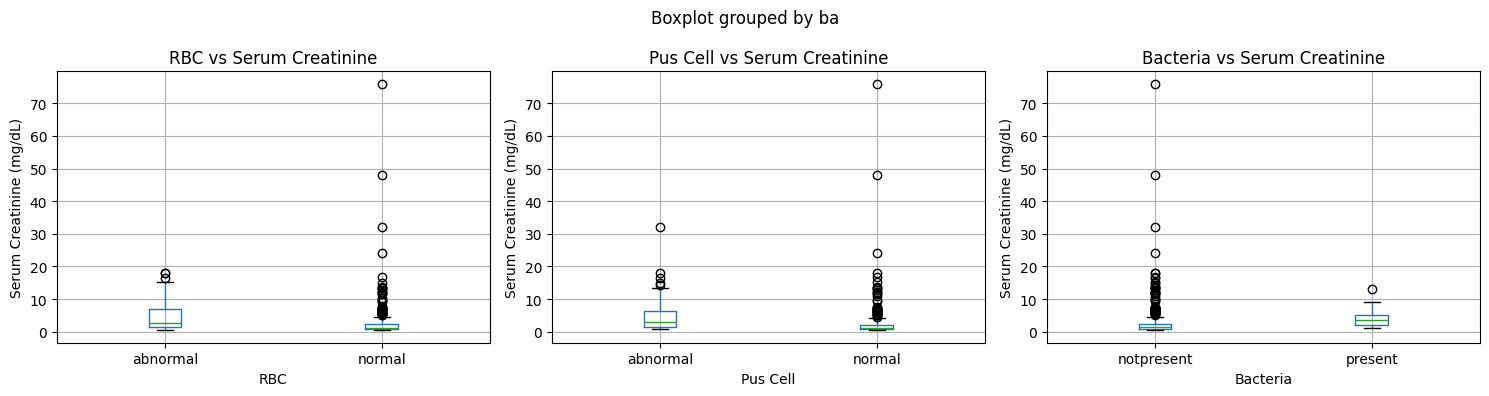

In [49]:
# Box plots: Categorical features vs Target
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

df_work.boxplot(column='sc', by='rbc', ax=axes[0])
axes[0].set_xlabel('RBC')
axes[0].set_ylabel('Serum Creatinine (mg/dL)')
axes[0].set_title('RBC vs Serum Creatinine')

df_work.boxplot(column='sc', by='pc', ax=axes[1])
axes[1].set_xlabel('Pus Cell')
axes[1].set_ylabel('Serum Creatinine (mg/dL)')
axes[1].set_title('Pus Cell vs Serum Creatinine')

df_work.boxplot(column='sc', by='ba', ax=axes[2])
axes[2].set_xlabel('Bacteria')
axes[2].set_ylabel('Serum Creatinine (mg/dL)')
axes[2].set_title('Bacteria vs Serum Creatinine')

plt.tight_layout()
plt.show()

## 4. Feature Engineering and Encoding

In [50]:
# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_work[col + '_encoded'] = le.fit_transform(df_work[col])
    label_encoders[col] = le
    print(f"\n{col} encoding:")
    for i, label in enumerate(le.classes_):
        print(f"  {label} -> {i}")

# Create final feature set
feature_columns = ['age', 'al', 'rbc_encoded', 'pc_encoded', 'ba_encoded']
X = df_work[feature_columns].copy()
y = df_work['sc'].copy()

print("\nFeature Matrix Shape:", X.shape)
print("Target Vector Shape:", y.shape)


rbc encoding:
  abnormal -> 0
  normal -> 1

pc encoding:
  abnormal -> 0
  normal -> 1

ba encoding:
  notpresent -> 0
  present -> 1

Feature Matrix Shape: (400, 5)
Target Vector Shape: (400,)


In [51]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

Training Set Size: (320, 5)
Test Set Size: (80, 5)


In [52]:
# Feature scaling (important for Perceptron)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled Training Set Shape:", X_train_scaled.shape)
print("Scaled Test Set Shape:", X_test_scaled.shape)

Scaled Training Set Shape: (320, 5)
Scaled Test Set Shape: (80, 5)


## 5. Model Training and Evaluation
### 5.1 Perceptron Model (Baseline)

In [53]:
# Train Perceptron model
# Note: Perceptron is typically for classification, but we'll adapt it for regression
# We'll use MLPRegressor instead, which is a neural network (Perceptron-based)
from sklearn.neural_network import MLPRegressor

perceptron_model = MLPRegressor(
    hidden_layer_sizes=(1,),  # Single neuron (perceptron)
    activation='identity',     # Linear activation for regression
    solver='sgd',              # Stochastic gradient descent
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

perceptron_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_perceptron_train = perceptron_model.predict(X_train_scaled)
y_pred_perceptron_test = perceptron_model.predict(X_test_scaled)

# Evaluation metrics
print("Perceptron Model Performance:")
print("\nTraining Set:")
print(f"  MSE: {mean_squared_error(y_train, y_pred_perceptron_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_perceptron_train)):.4f}")
print(f"  MAE: {mean_absolute_error(y_train, y_pred_perceptron_train):.4f}")
print(f"  R² Score: {r2_score(y_train, y_pred_perceptron_train):.4f}")

print("\nTest Set:")
print(f"  MSE: {mean_squared_error(y_test, y_pred_perceptron_test):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_perceptron_test)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_perceptron_test):.4f}")
print(f"  R² Score: {r2_score(y_test, y_pred_perceptron_test):.4f}")

Perceptron Model Performance:

Training Set:
  MSE: 29.5062
  RMSE: 5.4320
  MAE: 2.3229
  R² Score: -0.0027

Test Set:
  MSE: 40.9986
  RMSE: 6.4030
  MAE: 3.0443
  R² Score: -0.0365


### 5.2 XGBoost Model (Ensemble)

In [54]:
# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

# Evaluation metrics
print("XGBoost Model Performance:")
print("\nTraining Set:")
print(f"  MSE: {mean_squared_error(y_train, y_pred_xgb_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_xgb_train)):.4f}")
print(f"  MAE: {mean_absolute_error(y_train, y_pred_xgb_train):.4f}")
print(f"  R² Score: {r2_score(y_train, y_pred_xgb_train):.4f}")

print("\nTest Set:")
print(f"  MSE: {mean_squared_error(y_test, y_pred_xgb_test):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_test)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_xgb_test):.4f}")
print(f"  R² Score: {r2_score(y_test, y_pred_xgb_test):.4f}")

XGBoost Model Performance:

Training Set:
  MSE: 21.2377
  RMSE: 4.6084
  MAE: 1.5134
  R² Score: 0.2783

Test Set:
  MSE: 39.4790
  RMSE: 6.2832
  MAE: 2.6872
  R² Score: 0.0019


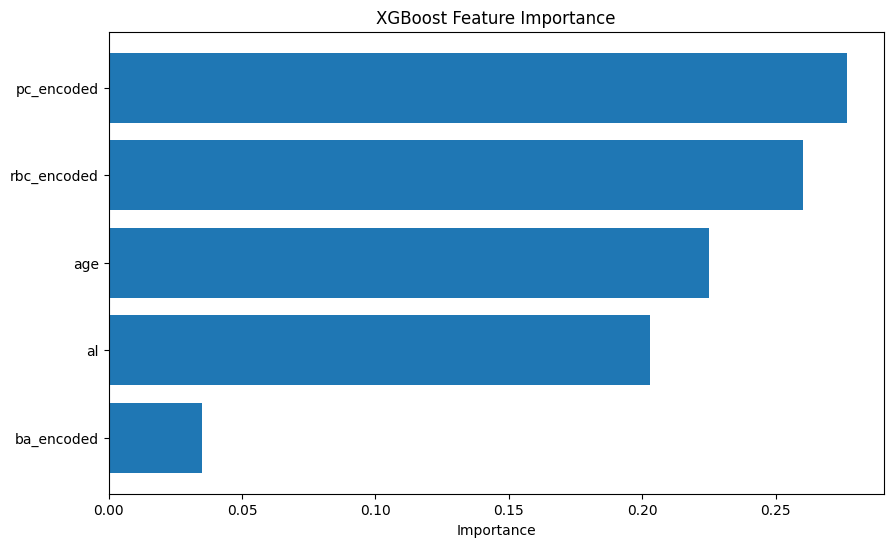


Feature Importance:
       Feature  Importance
3   pc_encoded    0.276685
2  rbc_encoded    0.260192
0          age    0.225047
1           al    0.203016
4   ba_encoded    0.035061


In [55]:
# Feature importance from XGBoost
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

### 5.3 CatBoost Model (Ensemble)

In [56]:
# Train CatBoost model
catboost_model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    random_state=42,
    verbose=False
)

catboost_model.fit(X_train, y_train)

# Predictions
y_pred_cat_train = catboost_model.predict(X_train)
y_pred_cat_test = catboost_model.predict(X_test)

# Evaluation metrics
print("CatBoost Model Performance:")
print("\nTraining Set:")
print(f"  MSE: {mean_squared_error(y_train, y_pred_cat_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_cat_train)):.4f}")
print(f"  MAE: {mean_absolute_error(y_train, y_pred_cat_train):.4f}")
print(f"  R² Score: {r2_score(y_train, y_pred_cat_train):.4f}")

print("\nTest Set:")
print(f"  MSE: {mean_squared_error(y_test, y_pred_cat_test):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_cat_test)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_cat_test):.4f}")
print(f"  R² Score: {r2_score(y_test, y_pred_cat_test):.4f}")

CatBoost Model Performance:

Training Set:
  MSE: 23.3855
  RMSE: 4.8359
  MAE: 1.8467
  R² Score: 0.2053

Test Set:
  MSE: 36.9814
  RMSE: 6.0812
  MAE: 2.6525
  R² Score: 0.0651


## 6. Model Comparison and Selection

Model Comparison:
        Model  Train_RMSE  Test_RMSE  Train_R2   Test_R2
0  Perceptron    5.431959   6.403013 -0.002696 -0.036504
1     XGBoost    4.608435   6.283228  0.278289  0.001914
2    CatBoost    4.835855   6.081234  0.205301  0.065056


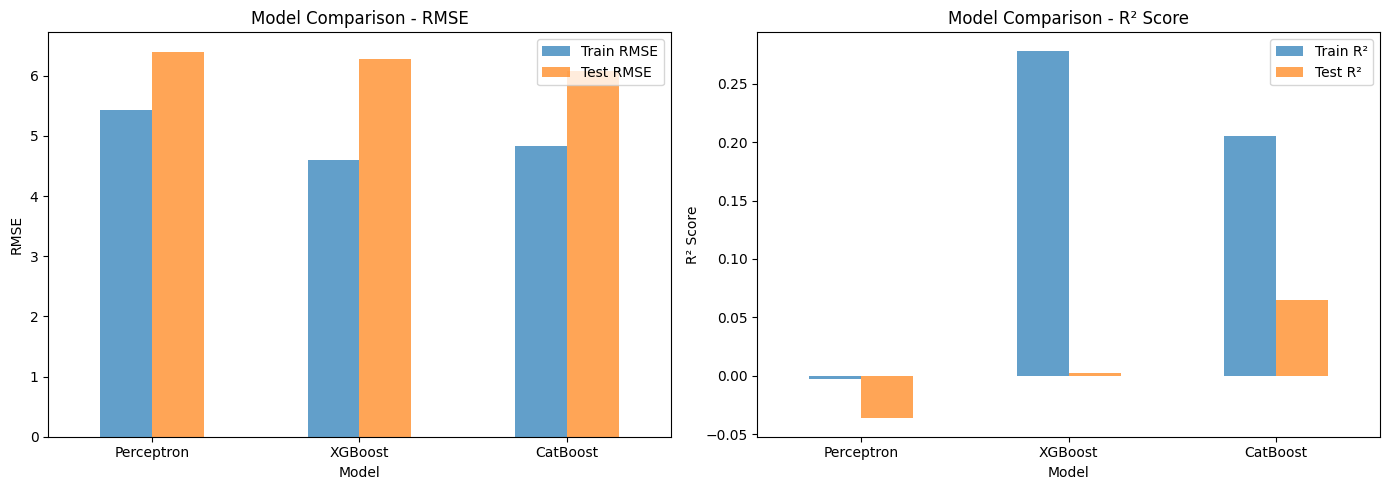

In [57]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Perceptron', 'XGBoost', 'CatBoost'],
    'Train_RMSE': [
        np.sqrt(mean_squared_error(y_train, y_pred_perceptron_train)),
        np.sqrt(mean_squared_error(y_train, y_pred_xgb_train)),
        np.sqrt(mean_squared_error(y_train, y_pred_cat_train))
    ],
    'Test_RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_perceptron_test)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb_test)),
        np.sqrt(mean_squared_error(y_test, y_pred_cat_test))
    ],
    'Train_R2': [
        r2_score(y_train, y_pred_perceptron_train),
        r2_score(y_train, y_pred_xgb_train),
        r2_score(y_train, y_pred_cat_train)
    ],
    'Test_R2': [
        r2_score(y_test, y_pred_perceptron_test),
        r2_score(y_test, y_pred_xgb_test),
        r2_score(y_test, y_pred_cat_test)
    ]
})

print("Model Comparison:")
print(results)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results.plot(x='Model', y=['Train_RMSE', 'Test_RMSE'], kind='bar', ax=axes[0], alpha=0.7)
axes[0].set_ylabel('RMSE')
axes[0].set_title('Model Comparison - RMSE')
axes[0].legend(['Train RMSE', 'Test RMSE'])
axes[0].set_xticklabels(results['Model'], rotation=0)

results.plot(x='Model', y=['Train_R2', 'Test_R2'], kind='bar', ax=axes[1], alpha=0.7)
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model Comparison - R² Score')
axes[1].legend(['Train R²', 'Test R²'])
axes[1].set_xticklabels(results['Model'], rotation=0)

plt.tight_layout()
plt.show()

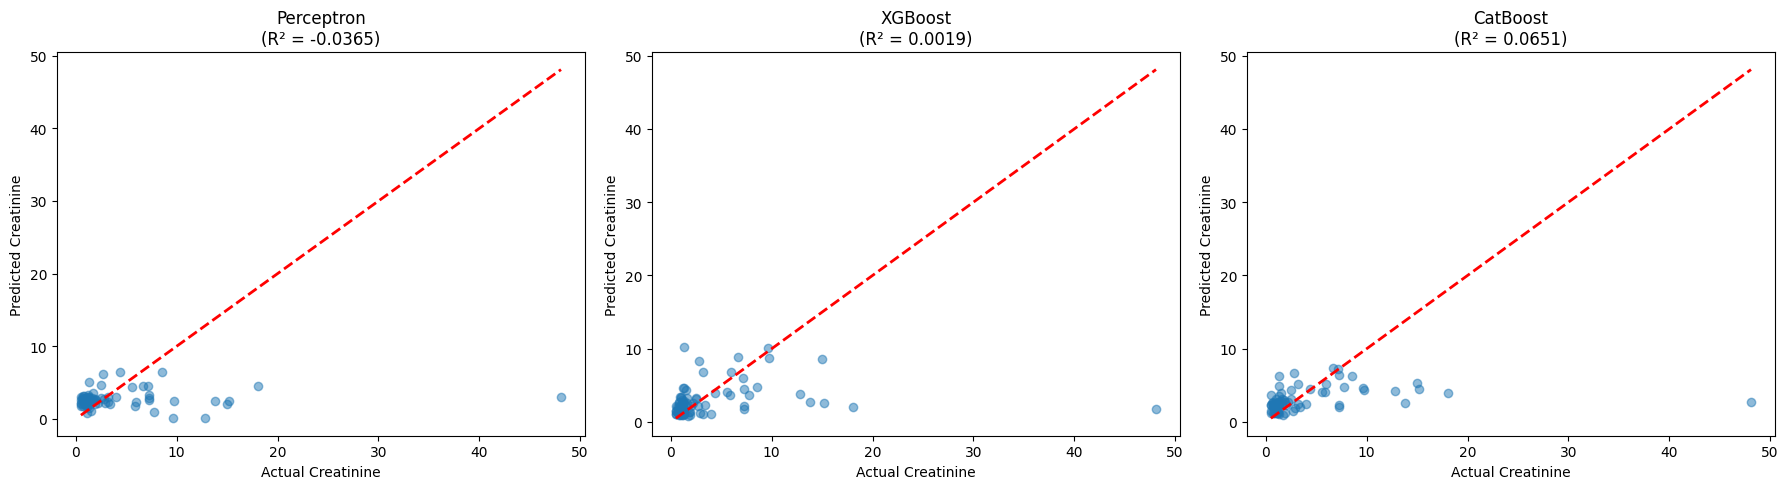

In [58]:
# Prediction vs Actual plots for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Perceptron
axes[0].scatter(y_test, y_pred_perceptron_test, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Creatinine')
axes[0].set_ylabel('Predicted Creatinine')
axes[0].set_title(f'Perceptron\n(R² = {r2_score(y_test, y_pred_perceptron_test):.4f})')

# XGBoost
axes[1].scatter(y_test, y_pred_xgb_test, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Creatinine')
axes[1].set_ylabel('Predicted Creatinine')
axes[1].set_title(f'XGBoost\n(R² = {r2_score(y_test, y_pred_xgb_test):.4f})')

# CatBoost
axes[2].scatter(y_test, y_pred_cat_test, alpha=0.5)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Creatinine')
axes[2].set_ylabel('Predicted Creatinine')
axes[2].set_title(f'CatBoost\n(R² = {r2_score(y_test, y_pred_cat_test):.4f})')

plt.tight_layout()
plt.show()

## 7. Save Best Model and Predictions for Solution 2

In [59]:
# Select best model based on test R² score
best_model_idx = results['Test_R2'].idxmax()
best_model_name = results.loc[best_model_idx, 'Model']

print(f"Best Model: {best_model_name}")
print(f"Test R² Score: {results.loc[best_model_idx, 'Test_R2']:.4f}")
print(f"Test RMSE: {results.loc[best_model_idx, 'Test_RMSE']:.4f}")

# Select best model predictions
if best_model_name == 'Perceptron':
    best_predictions = y_pred_perceptron_test
    best_model = perceptron_model
elif best_model_name == 'XGBoost':
    best_predictions = y_pred_xgb_test
    best_model = xgb_model
else:
    best_predictions = y_pred_cat_test
    best_model = catboost_model

Best Model: CatBoost
Test R² Score: 0.0651
Test RMSE: 6.0812


In [60]:
# Save predictions and additional data needed for Solution 2
import pickle

# Prepare data for Solution 2
solution2_data = {
    'X_test': X_test,
    'y_test_actual': y_test,
    'y_test_predicted': best_predictions,
    'best_model_name': best_model_name,
    'best_model': best_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'df_original': df,
    'test_indices': X_test.index
}

# Save to pickle file
with open('solution1_output.pkl', 'wb') as f:
    pickle.dump(solution2_data, f)

print("Data saved successfully for Solution 2!")
print(f"\nPredicted Creatinine values (first 10):")
print(best_predictions[:10])

Data saved successfully for Solution 2!

Predicted Creatinine values (first 10):
[1.0839218  2.23629112 4.40050485 4.18083772 4.02115116 5.25630414
 1.26712796 3.09649606 2.24897226 2.46758688]


## 8. Summary and Conclusion

In [61]:
print("=" * 70)
print("SOLUTION 1: CREATININE PREDICTION - SUMMARY")
print("=" * 70)
print(f"\nDataset Size: {len(df)} samples")
print(f"Features Used: {len(feature_columns)} features")
print(f"  - Numeric: Age, Albumin")
print(f"  - Categorical (encoded): RBC, Pus Cell, Bacteria")
print(f"\nTarget Variable: Serum Creatinine (mg/dL)")
print(f"\nTrain/Test Split: 80/20")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print("\n" + "=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print(results.to_string(index=False))
print("\n" + "=" * 70)
print(f"BEST MODEL: {best_model_name}")
print("=" * 70)
print(f"Test R² Score: {results.loc[best_model_idx, 'Test_R2']:.4f}")
print(f"Test RMSE: {results.loc[best_model_idx, 'Test_RMSE']:.4f}")
print("\nPredictions saved for Solution 2 (CKD Classification)")
print("=" * 70)

SOLUTION 1: CREATININE PREDICTION - SUMMARY

Dataset Size: 400 samples
Features Used: 5 features
  - Numeric: Age, Albumin
  - Categorical (encoded): RBC, Pus Cell, Bacteria

Target Variable: Serum Creatinine (mg/dL)

Train/Test Split: 80/20
Training Samples: 320
Test Samples: 80

MODEL PERFORMANCE SUMMARY
     Model  Train_RMSE  Test_RMSE  Train_R2   Test_R2
Perceptron    5.431959   6.403013 -0.002696 -0.036504
   XGBoost    4.608435   6.283228  0.278289  0.001914
  CatBoost    4.835855   6.081234  0.205301  0.065056

BEST MODEL: CatBoost
Test R² Score: 0.0651
Test RMSE: 6.0812

Predictions saved for Solution 2 (CKD Classification)
